In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
import tarfile
import os
import matplotlib.pyplot as plt

In [ ]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [00:03<00:00, 39960448.22it/s]


In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [ ]:
dataset = ImageFolder(root='./data/cifar10/train', transform=ToTensor())
len(dataset)

50000

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
train_len = 45000
valid_len = len(dataset) - train_len
train_ds, valid_ds = random_split(dataset, [train_len, valid_len])
len(train_ds), len(valid_ds)

(45000, 5000)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)
len(train_loader), len(valid_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(352, 20)

In [ ]:
def accuracy_score(output, labels):
  _, preds = torch.max(output, dim=1)
  correct_preds = torch.sum(preds == labels).item()
  total_preds = len(preds)
  return torch.tensor(correct_preds / total_preds)

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
class ImageClassification(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    acc = accuracy_score(outputs, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  def epoch_validation_step(self, output):
    losses = [x['val_loss'] for x in output]
    epoch_loss = torch.stack(losses).mean()
    accs = [x['val_acc'] for x in output]
    epoch_accs = torch.stack(accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accs.item()}
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class Cifar10Model(ImageClassification):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, img):
    return self.network(img)

In [ ]:
model = Cifar10Model()
model

Cifar10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
to_device(model, device)

Cifar10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [ ]:
def evaluate(model, valid_loader):
  model.eval()
  output = [model.validation_step(batch) for batch in valid_loader]
  return model.epoch_validation_step(output)

In [ ]:
def fit(epoch_num, lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epoch_num):
    # Training
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, valid_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
model = to_device(Cifar10Model(), device)

In [ ]:
evaluate(model, valid_loader)

{'val_loss': 2.3029754161834717, 'val_acc': 0.10143611580133438}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = []

In [ ]:
history += fit(num_epochs, lr, model, train_loader, valid_loader, opt_func)

Epoch [0], train_loss: 1.7404, val_loss: 1.4032, val_acc: 0.4828
Epoch [1], train_loss: 1.1922, val_loss: 1.0904, val_acc: 0.6107
Epoch [2], train_loss: 0.9071, val_loss: 0.8612, val_acc: 0.6917
Epoch [3], train_loss: 0.7284, val_loss: 0.7562, val_acc: 0.7375
Epoch [4], train_loss: 0.5847, val_loss: 0.7412, val_acc: 0.7535
Epoch [5], train_loss: 0.4736, val_loss: 0.7616, val_acc: 0.7501
Epoch [6], train_loss: 0.3672, val_loss: 0.7178, val_acc: 0.7751
Epoch [7], train_loss: 0.2742, val_loss: 0.8133, val_acc: 0.7691
Epoch [8], train_loss: 0.2064, val_loss: 0.9325, val_acc: 0.7593
Epoch [9], train_loss: 0.1491, val_loss: 1.0434, val_acc: 0.7707


Text(0, 0.5, 'acc')

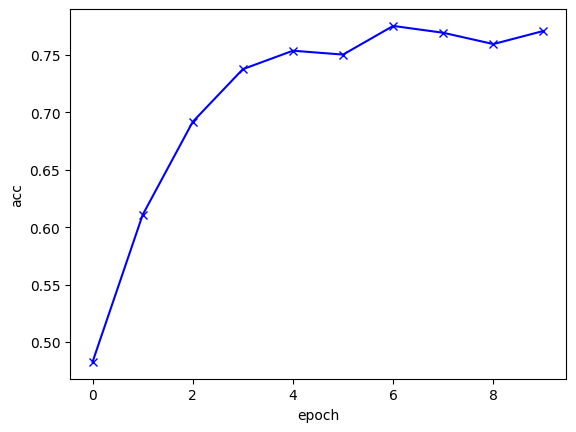

In [ ]:
val_accs = [x.get('val_acc') for x in history]
plt.plot(val_accs, '-bx')
plt.xlabel('epoch')
plt.ylabel('acc')

In [ ]:
# val_loss = [x.get('val_loss') for x in history]
# plt.plot(val_loss, '-rx')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [ ]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
def predict_image(model, img):
  img = to_device(img.unsqueeze(0), device)
  output = model(img)
  _, pred = torch.max(output, dim=1)
  return dataset.classes[pred[0].item()]

In [ ]:
test_ds = ImageFolder(root='./data/cifar10/test', transform=ToTensor())

Predict: airplane
Label: airplane


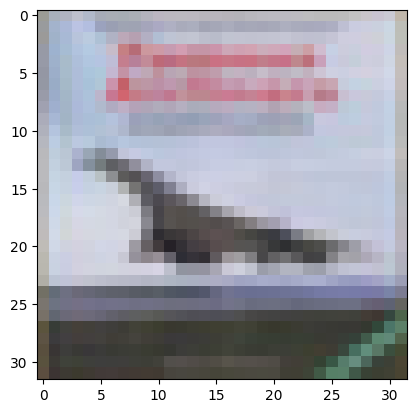

In [ ]:
image, label = test_ds[0]
plt.imshow(image.permute(1, 2, 0))
print('Predict:', predict_image(model, image))
print('Label:', dataset.classes[label])

Predict: automobile
Label: automobile


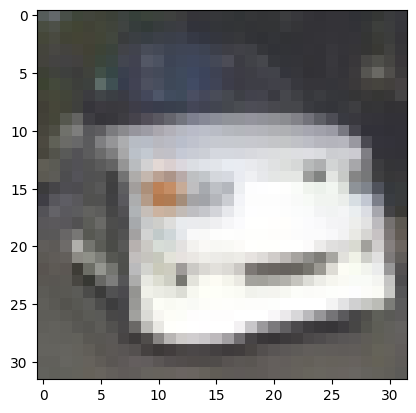

In [ ]:
image, label = test_ds[1219]
plt.imshow(image.permute(1, 2, 0))
print('Predict:', predict_image(model, image))
print('Label:', dataset.classes[label])